In [1]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.nn.functional import pairwise_distance

from sklearn.metrics import f1_score, precision_score, recall_score

# Siamese model

In [2]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_size, embedding_size=128):
        super(SiameseNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, embedding_size),
        )
    
    def forward(self, x):
        x = self.fc(x)
        return x

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights_path = '/kaggle/input/cds-siamese-tuning/pytorch/512-3linear/1/lr 0.0000001.pt'
siamese_model = SiameseNetwork(input_size=768, embedding_size=128).to(device)
siamese_model.load_state_dict(torch.load(weights_path, map_location=device))
siamese_model.eval()

SiameseNetwork(
  (fc): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
  )
)

# Load dataset
1. Load reduced triplet dataset
2. Load reduced training dataset with BLIP embeddings

In [4]:
# types
df_train_dtype = {
    'similar': 'str',
    'anchor':'str',
    'dissimilar':'str',
    'similar_group': 'Int64',
    'dissimilar_group': 'Int64'
}

df_train_blip_dtype = {
    'image_path': 'str',
    'blip': 'object'
}

In [5]:
df_train_blip = pd.read_csv('/kaggle/input/new-cds-triplets-images/reduced_training_with_blip.csv', dtype=df_train_blip_dtype)

# Get centroid embeddings for each group


In [6]:
df_train_blip = df_train_blip.set_index('image_path') # for faster lookup
df_train_blip['blip_siamese'] = None

In [7]:
centroid_columns=['group', 'blip_centroid', 'blip_siamese_centroid']
df_train_centroid = pd.DataFrame(columns=centroid_columns)
df_train_centroid['group'] = pd.Series(dtype='Int64')
df_train_centroid['blip_centroid'] = pd.Series(dtype='object')
df_train_centroid['blip_siamese_centroid'] = pd.Series(dtype='object')

df_train_centroid = df_train_centroid.set_index('group') # for faster lookup

In [8]:
unique_training_groups = df_train_blip['group'].unique()

## Base BLIP model
Get centroid embedding for each group with the BLIP model \
Store the embedding under the `blip_centroid` column

In [9]:
for group in unique_training_groups:
    df_group = df_train_blip[df_train_blip['group'] == group]
    group_embeddings = [np.array(ast.literal_eval(embedding)) for embedding in df_group['blip']]
    df_train_centroid.at[group, 'blip_centroid'] = np.mean(group_embeddings, axis=0).tolist()

## Custom Siamese model
Get the embedding of each group with our custom Siamese model \
Store the embedding under the `blip_siamese_centroid` column

In [10]:
# getting blip_siamese
with torch.no_grad():
    for image_path,row in df_train_blip.iterrows():
        blip_embedding = ast.literal_eval(row['blip'])
        blip_embedding = torch.tensor(blip_embedding).float().to(device)
        
        siamese_embedding = siamese_model(blip_embedding)
        siamese_embedding = siamese_embedding.cpu().squeeze(0) # in cpu memory

        df_train_blip.at[image_path, 'blip_siamese'] = siamese_embedding.numpy()

# getting blip_siamese_centroid
for group in unique_training_groups:
    df_group = df_train_blip[df_train_blip['group'] == group]
    group_siamese_embeddings = [np.array(embedding) for embedding in df_group['blip_siamese']]
    df_train_centroid.at[group, 'blip_siamese_centroid'] = np.mean(group_siamese_embeddings, axis=0).tolist()

# Evaluation with validation dataset

## Load validation dataset

In [11]:
df_validation_blip = pd.read_csv('/kaggle/input/new-cds-triplets-images/validation_with_blip.csv')
df_validation_blip['blip_siamese'] = pd.Series(dtype='object')
df_validation_blip['predicted_group_blip'] = None # int
df_validation_blip['predicted_group_siamese'] = None # int

validation_size = len(df_validation_blip)
df_validation_blip = df_validation_blip.sample(n=validation_size, random_state=69).reset_index(drop=True).set_index('image_path') # set seed for reproducibility

## Feed validation dataset to custom Siamese model and get predicted group

In [12]:
def find_closest_group(embedding, centroid_embeddings):
    min_distance = float('inf')
    closest_group = None
    embedding = torch.tensor(embedding).float()
    for group, ref_embedding in centroid_embeddings.items():
        ref_embedding = torch.tensor(ref_embedding).float()
        distance = pairwise_distance(embedding.unsqueeze(0), ref_embedding.unsqueeze(0))
        if distance < min_distance:
            min_distance = distance
            closest_group = group
    return closest_group

1. BLIP model
2. Siamese model

In [13]:
centroid_blip = df_train_centroid.groupby('group')['blip_centroid'].first().to_dict()
centroid_blip_siamese = df_train_centroid.groupby('group')['blip_siamese_centroid'].first().to_dict()

for image_path, row in df_validation_blip.iterrows():
    blip_embedding = ast.literal_eval(row['blip'])
    features = torch.tensor(blip_embedding).float()
    
    # blip model
    predicted_group_blip = find_closest_group(features, centroid_blip)
    df_validation_blip.at[image_path, 'predicted_group_blip'] = predicted_group_blip
    
    # siamese model
    with torch.no_grad():
        embedding_siamese = siamese_model(features.to(device).unsqueeze(0))
    validation_embedding = embedding_siamese.cpu().squeeze(0)
    df_validation_blip.at[image_path, 'blip_siamese'] = validation_embedding.numpy()

    predicted_group_siamese = find_closest_group(validation_embedding, centroid_blip_siamese)
    df_validation_blip.at[image_path, 'predicted_group_siamese'] = predicted_group_siamese

/tmp/ipykernel_18/459130396.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  embedding = torch.tensor(embedding).float()


In [14]:
df_validation_blip.head()

,Unnamed: 0,group,blip,blip_siamese,predicted_group_blip,predicted_group_siamese
image_path,,,,,,
sofas/lounge-chairs/88037_image_0_resized.jpg,10,373,"[0.6056516170501709, -0.5458513498306274, -0.1...","[0.18953604, -0.16485232, 0.08112041, 0.041208...",91,451
sofas/l-shape/66878_image_0_resized.jpg,206,313,"[-0.18993604183197021, -0.0453345850110054, 0....","[0.11096546, -0.07141003, 0.11480144, -0.05040...",317,112
chairs/bean-bags-poufs/19867_image_0_resized.jpg,112,555,"[-0.011462010443210602, 0.1260293424129486, 0....","[0.17869607, -0.08044125, 0.12983821, 0.057185...",583,555
sofas/leather-sofas/88719_image_0_resized.jpg,197,319,"[-0.1547168493270874, -0.4287767708301544, -0....","[0.12059736, -0.09684514, 0.14447302, 0.001562...",319,319
sofas/lounge-chairs/91938_image_0_resized.jpg,193,342,"[0.021385686472058296, -0.4172566831111908, -0...","[0.20479816, -0.18976547, 0.1336778, 0.0883924...",342,342


### Calculate F1, precision and recall score
1. BLIP model
2. Siamese model

In [15]:
true_groups = [x for x in df_validation_blip['group'].tolist()]
predicted_groups_blip = df_validation_blip['predicted_group_blip'].tolist()
predicted_groups_siamese = df_validation_blip['predicted_group_siamese'].tolist()

In [16]:
average_method = 'weighted'

f1_blip = f1_score(true_groups, predicted_groups_blip, average=average_method)
precision_blip = precision_score(true_groups, predicted_groups_blip, average=average_method)
recall_blip = recall_score(true_groups, predicted_groups_blip, average=average_method)

f1_siamese = f1_score(true_groups, predicted_groups_siamese, average=average_method)
precision_siamese = precision_score(true_groups, predicted_groups_siamese, average=average_method)
recall_siamese = recall_score(true_groups, predicted_groups_siamese, average=average_method)

print(f"Precision Score for BLIP: {precision_blip:.2f}")
print(f"Precision Score for Siamese: {precision_siamese:.2f}\n")

print(f"Recall Score for BLIP: {recall_blip:.2f}")
print(f"Recall Score for Siamese: {recall_siamese:.2f}\n")

print(f"F1 Score for BLIP: {f1_blip:.2f}")
print(f"F1 Score for Siamese: {f1_siamese:.2f}")

Precision Score for BLIP: 0.45
Precision Score for Siamese: 0.47

Recall Score for BLIP: 0.38
Recall Score for Siamese: 0.35

F1 Score for BLIP: 0.38
F1 Score for Siamese: 0.35


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall

## Find top 5 similar products
For each validation image, compare it against the entire training set and find the top 5 nearest images

In [17]:

def display_image_grid(results, n, label='', save_path='results_grid.png'):
   
    num_rows = n
    num_columns = 6  # 1 validation image + 5 training images
    
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_columns, figsize=(20, 10))
    
    for i, result in enumerate(results[:n]):
        validation_image = Image.open('/kaggle/input/cds-sofas-chairs-validation/validation/' + result[0])
        axs[i, 0].imshow(validation_image)
        axs[i, 0].set_title("Validation")
        axs[i, 0].axis('off')
        
        for j, training_image_path in enumerate(result[1], start=1):
            training_image = Image.open('/kaggle/input/cds-sofas-chairs-training/training/' + training_image_path)
            axs[i, j].imshow(training_image)
            axs[i, j].set_title(f"Top {j}")
            axs[i, j].axis('off')
    
    plt.tight_layout()
    plt.savefig(f'{label}_{save_path}')
    plt.show()

In [18]:
blip_results = []
siamese_results = []

train_blip_embeddings = torch.stack([torch.tensor(ast.literal_eval(embedding)) for embedding in df_train_blip['blip']])
train_siamese_embeddings = torch.stack([torch.tensor(embedding) for embedding in df_train_blip['blip_siamese']])

for image_path, row in df_validation_blip.iterrows():
    
    validation_blip_embedding = torch.tensor(ast.literal_eval(row['blip'])).unsqueeze(0)
    validation_siamese_embedding = torch.tensor(row['blip_siamese']).unsqueeze(0)  # Add batch dimension if not already a tensor
    
    blip_distances = pairwise_distance(validation_blip_embedding, train_blip_embeddings)
    siamese_distances = pairwise_distance(validation_siamese_embedding, train_siamese_embeddings)
    
    _, top_5_indices_blip = torch.topk(blip_distances, 5, largest=False)
    top_5_image_paths_blip = df_train_blip.iloc[top_5_indices_blip.cpu().tolist()].index.tolist()
    
    _, top_5_indices_siamese = torch.topk(siamese_distances, 5, largest=False)
    top_5_image_paths_siamese = df_train_blip.iloc[top_5_indices_siamese.cpu().tolist()].index.tolist()

    blip_results.append((image_path, top_5_image_paths_blip))
    siamese_results.append((image_path, top_5_image_paths_siamese))

Display results

BLIP


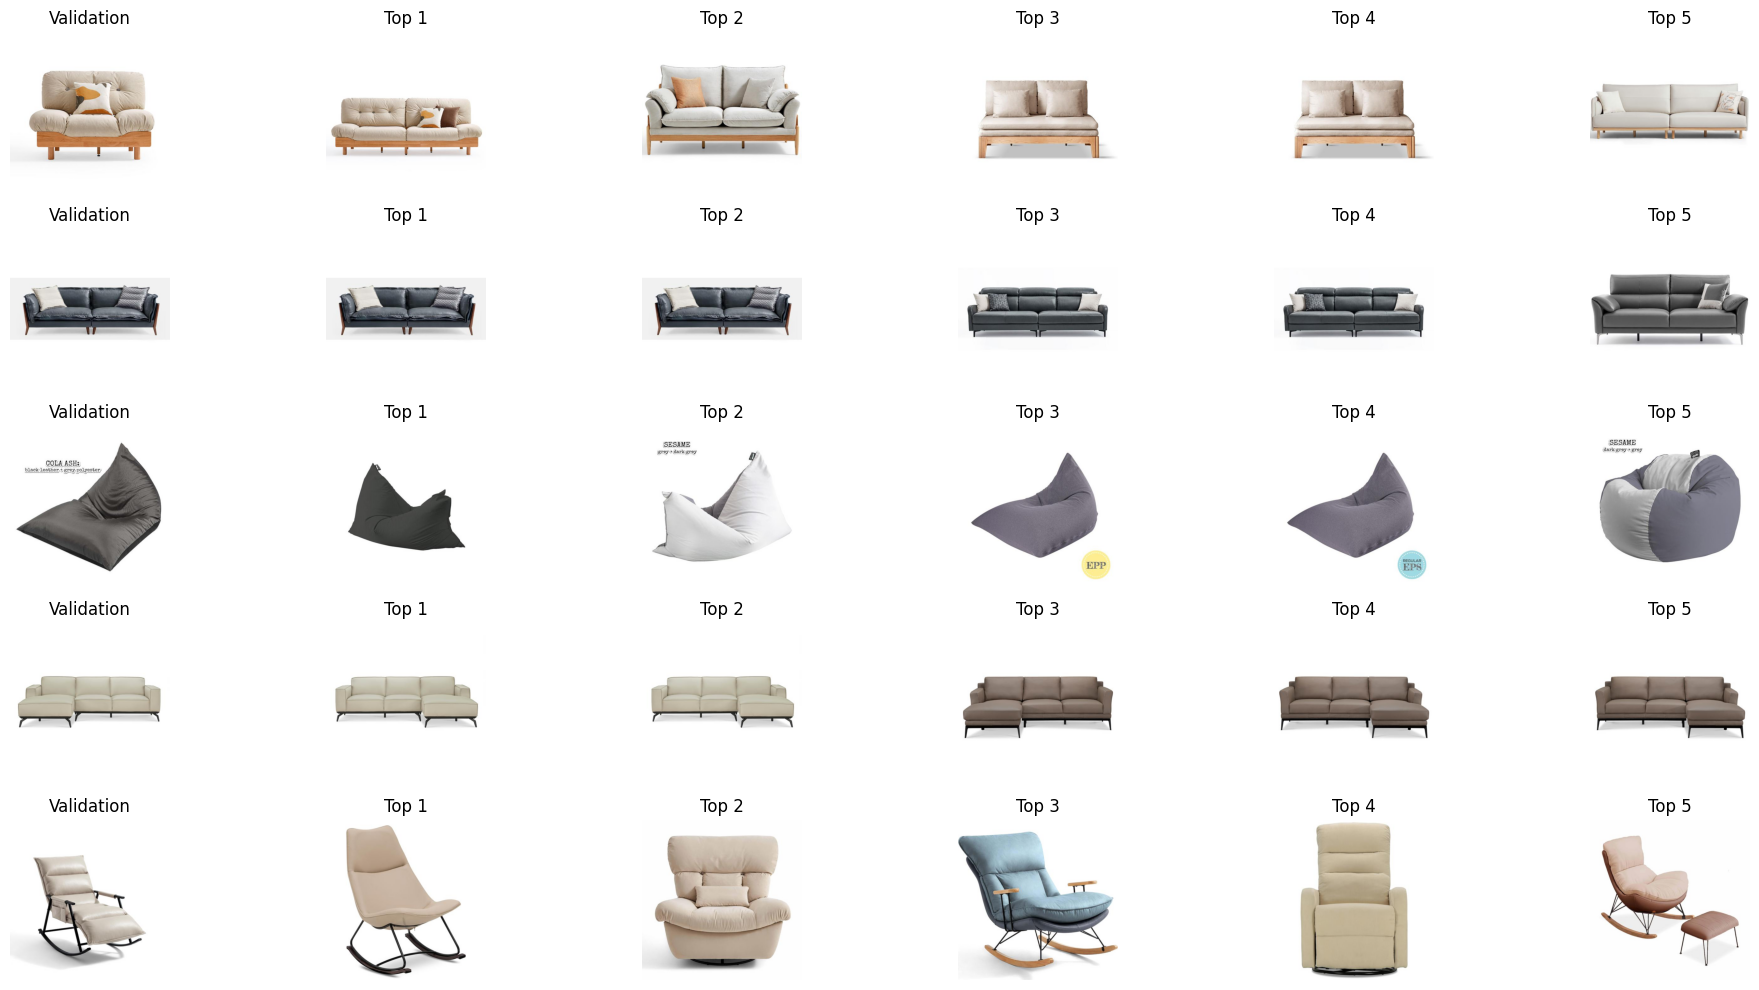


SIAMESE


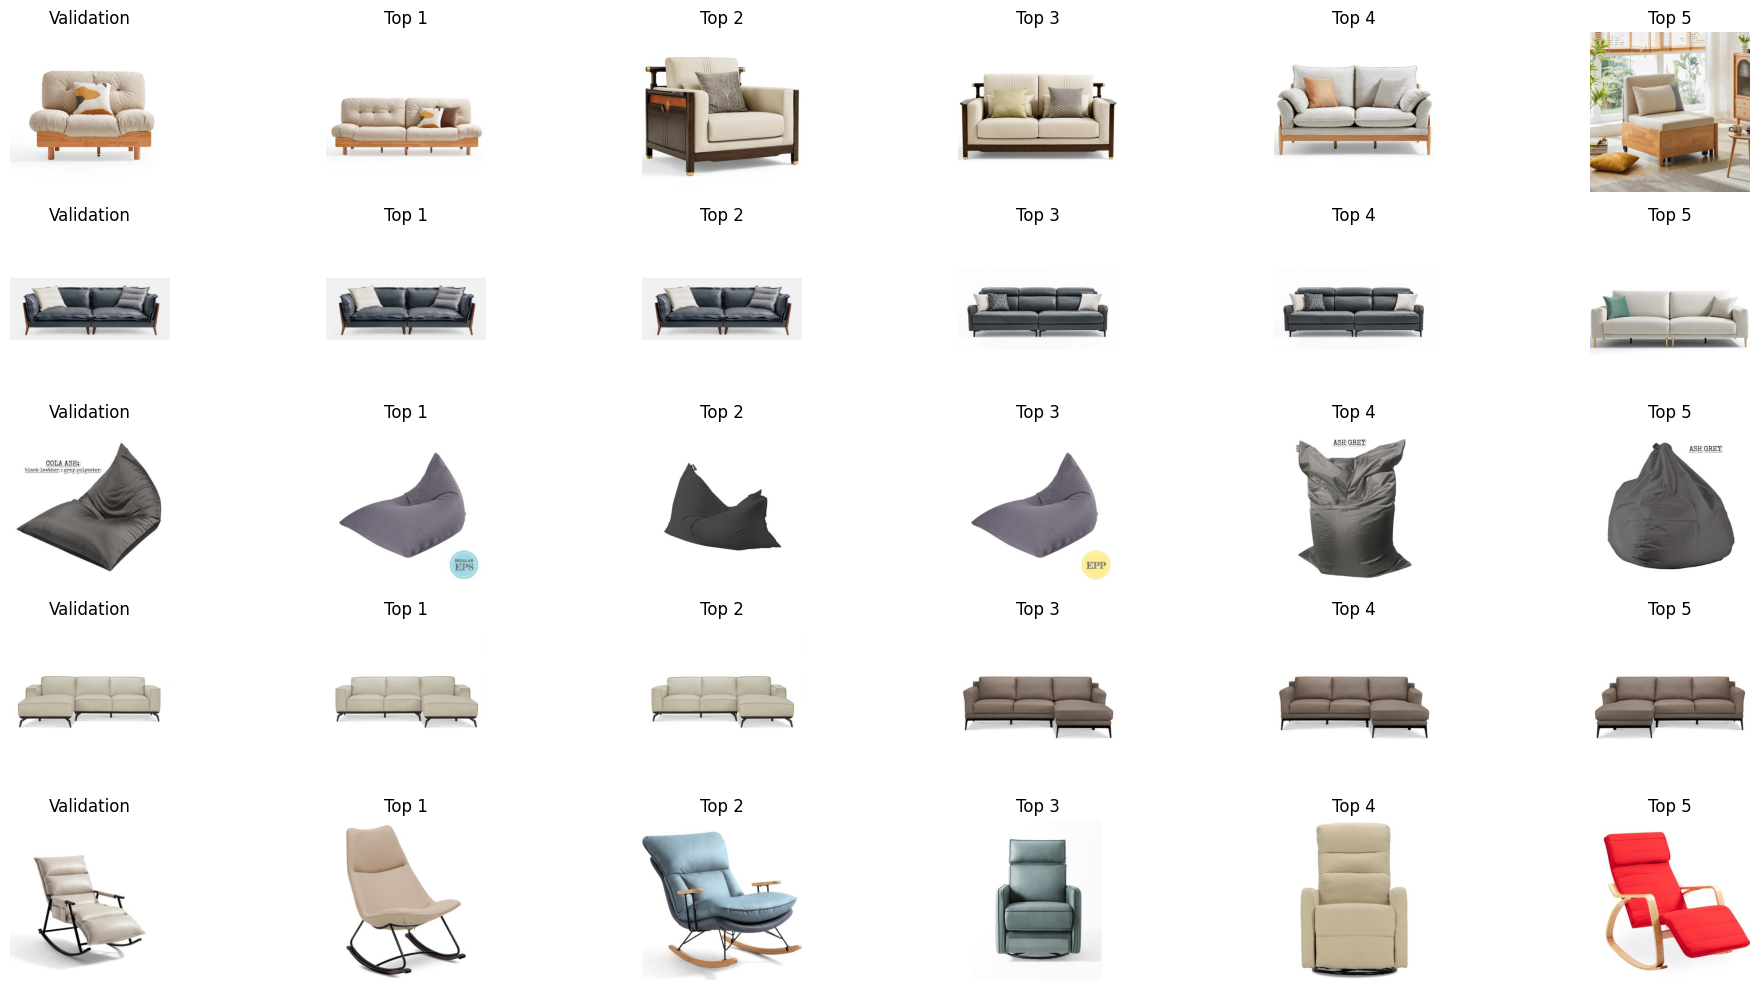

In [19]:
print("BLIP")
display_image_grid(blip_results, n=5, label="BLIP")

print("\nSIAMESE")
display_image_grid(siamese_results, n=5, label="Siamese")

# Visualise with dot cluster map

In [20]:
from sklearn.manifold import TSNE

num_samples = df_train_blip.shape[0]
embeddings = np.stack(df_train_blip['blip_siamese'].values)
group_labels = np.stack(df_train_blip['group'].values)

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

df_2d = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df_2d['group_labels'] = group_labels


/tmp/ipykernel_18/2789116499.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the right side of the layout to make room for the legend


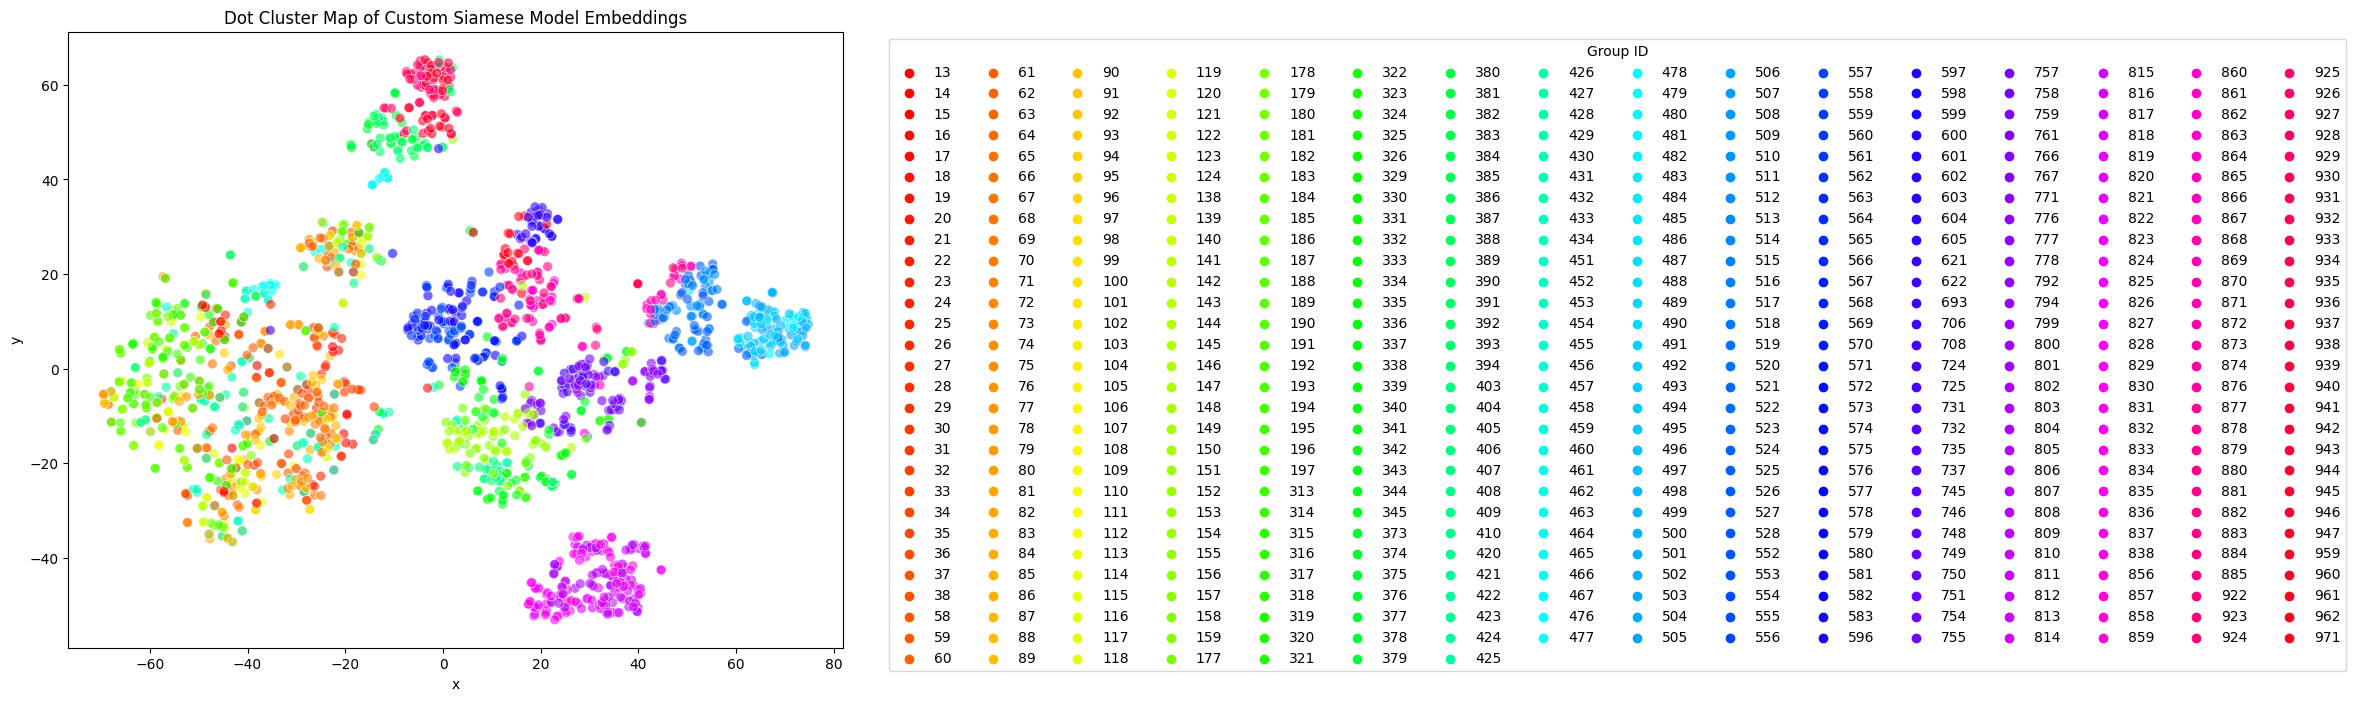

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_labels = df_2d['group_labels'].unique()
n_unique_labels = len(unique_labels)

palette = sns.color_palette("hsv", n_unique_labels)
color_map = {label: color for label, color in zip(unique_labels, palette)}

plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_2d, 
    x='x', y='y', 
    hue='group_labels', 
    palette=color_map,
    s=50, alpha=0.6
).set(title='Dot Cluster Map of Custom Siamese Model Embeddings')

ncol_legend = int(n_unique_labels / 30) + 1

plt.legend(title='Group ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=ncol_legend)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('scatter_plot.png', bbox_inches='tight')
plt.show()